In [40]:
from math import pi

import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import ADSTFT, DSTFT

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(1802);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [41]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

In [42]:
stride = 50
support = 1_000
epochs = 100_000
lr = 100
win_min = 500
threshold = 1
patience = 9
win_length = 600

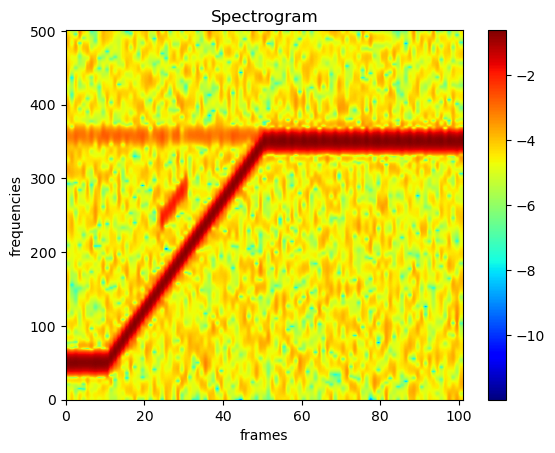

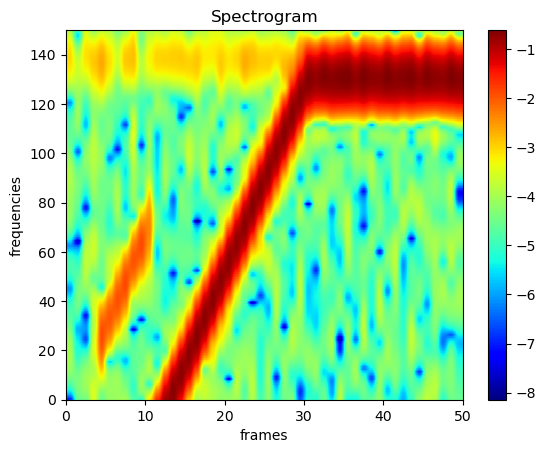

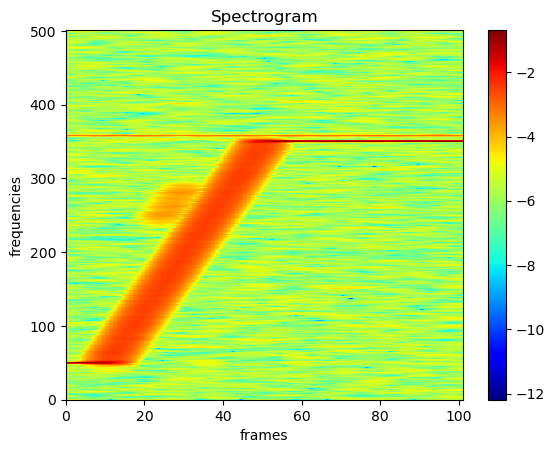

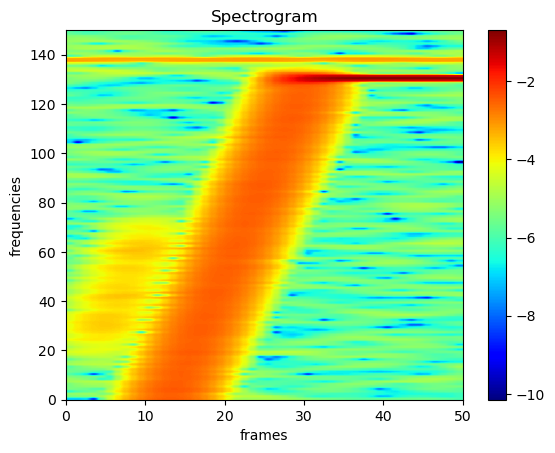

In [43]:
for win_length in [100, 1_000]:
    dstft = DSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft = dstft(x)
    dstft.print(spec, weights=False, wins=False, bar=True)
    dstft.print(
        spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False,
    )

In [44]:
def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(dim=-1)  # B
    return entropy.mean()

Classical STFT : Single window length DSTFT

nb of epochs: 43, window length: 234.9


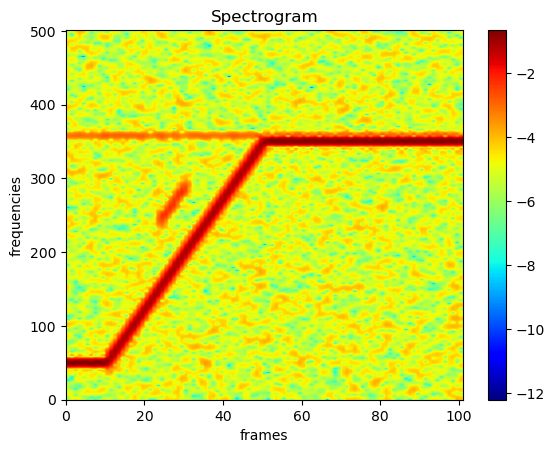

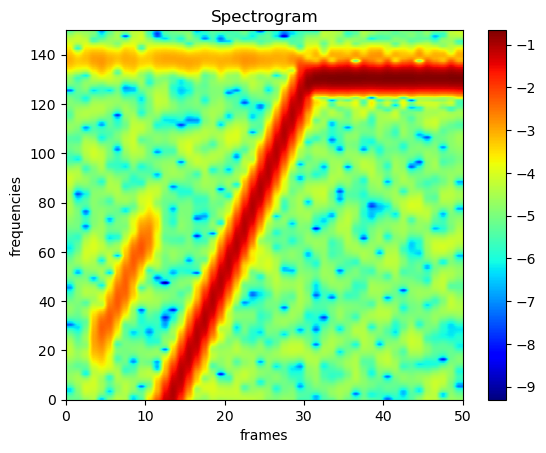

In [45]:
dstft = DSTFT(
    x,
    win_length=win_length,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=patience,
)

min_err = 100
min_win = 0

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)

    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()

    if opt.param_groups[0]["lr"] < threshold:
        break

print(f"nb of epochs: {epoch}, window length: {dstft.win_length.item():.1f}")
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

Adaptive DSTFT: time-frequency varying window length DSTFT

nb of epochs: 43


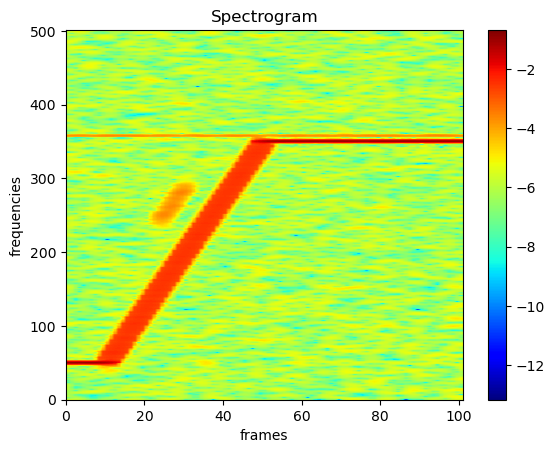

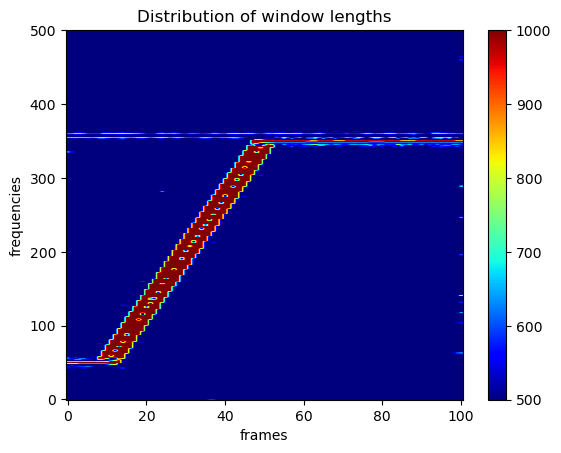

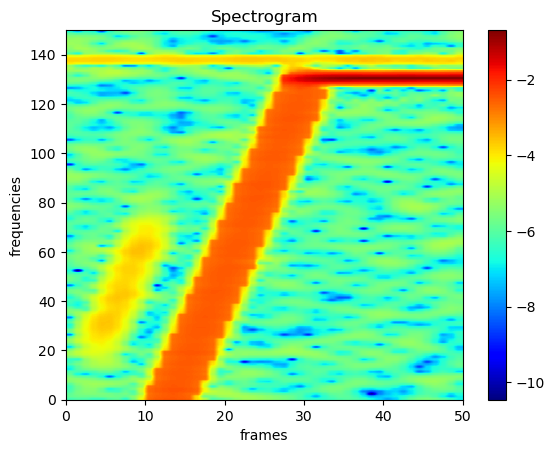

In [46]:
dstft = ADSTFT(
    x,
    win_length=500,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p="tf",
    win_min=win_min,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=.1, patience=patience,
)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = (
        entropy_loss(spec)
        + 0.004
        * (
            dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2)
            + dstft.actual_win_length.diff(dim=1)[:-1].pow(2)
            + torch.finfo(x.dtype).eps
        )
        .sqrt()
        .mean()
    )
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break

print(f"nb of epochs: {epoch}")
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

Time-varying window and hop lengths

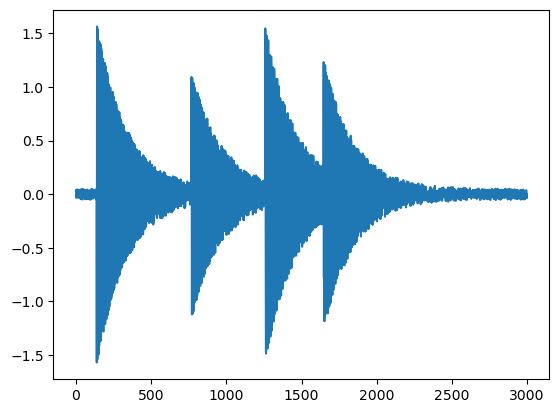

In [57]:
fs = 1e3
t = torch.arange(0, 3, 1 / fs)
L = t.shape[0]
mark_list = [138, 768, 1259, 1647]
index_impulse = torch.tensor(mark_list).long()

alpha = 5
f = torch.ones_like(t)
f[:768] = 250 * f[:768]
f[768:1259] = 200 * f[768:1259]
f[1259:1647] = 100 * f[1259:1647]
f[1647:] = 300 * f[1647:]
x = torch.sin(torch.cumsum(2 * pi * f, dim=0) / fs)
y = torch.zeros_like(x)
y[index_impulse] = 1 + torch.rand(index_impulse.shape)
z = torch.exp(-t * alpha)
z1 = torch.fft.ifft(torch.fft.fft(z) * torch.fft.fft(y))
x = x * z1.real + .1 * torch.rand(f.shape)
x = x - x.mean()
x = x[None, :].to(device)
plt.plot(x[0].cpu())

In [58]:
def kurtosis_loss(x):
    kur = x.pow(4).mean(dim=1) / x.pow(2).mean(dim=1).pow(2)  # B, T
    return kur

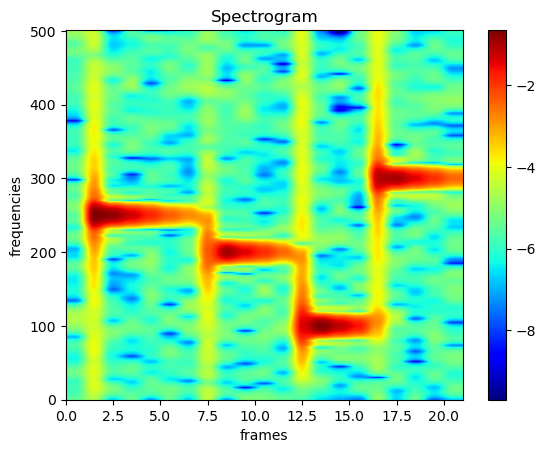

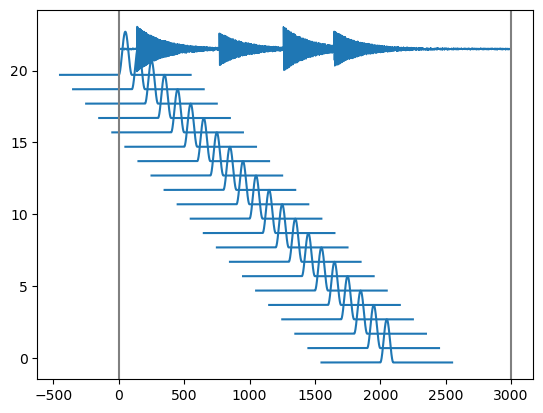

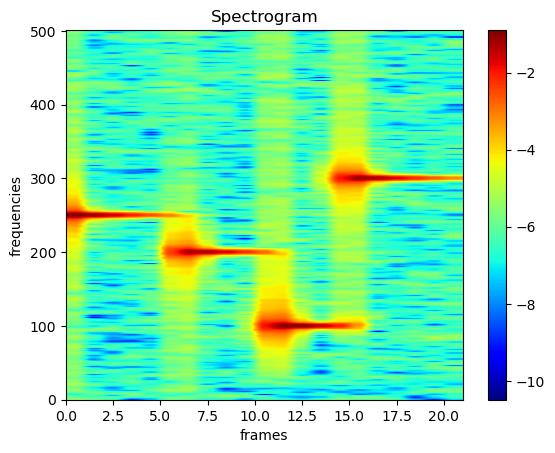

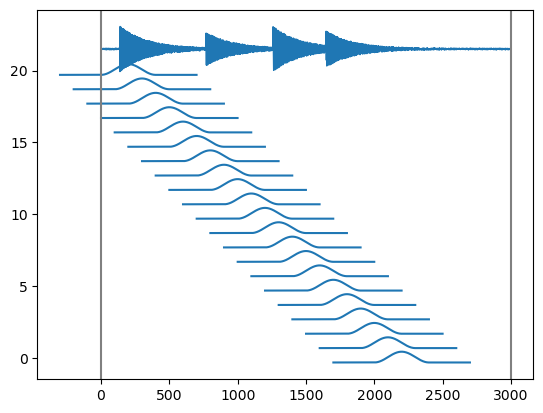

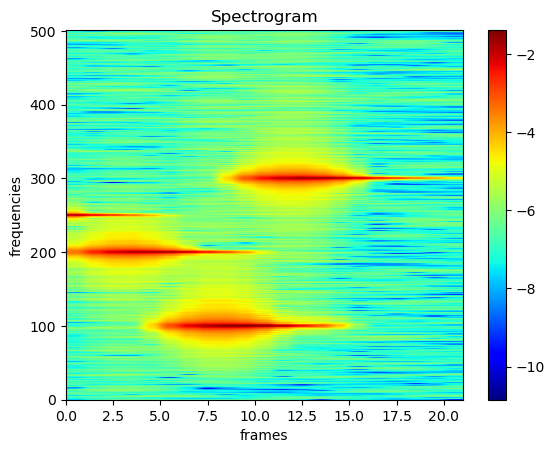

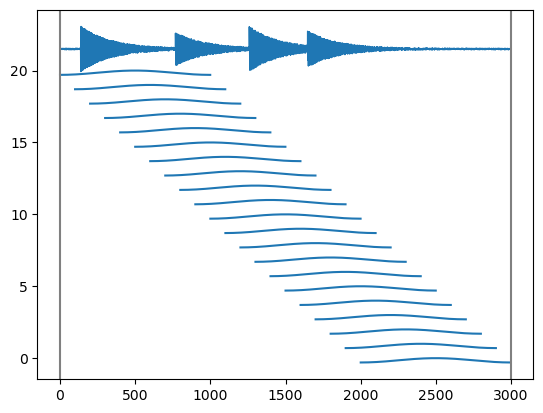

In [59]:
for win_length in [100, 400, 1_000]:
    dstft = DSTFT(
        x,
        win_length=win_length,
        support=1_000,
        stride=100,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p="t",
        stride_p=None,
        first_frame=True,
    )
    spec, *_ = dstft(x)
    dstft.print(spec, x, weights=False, bar=True)

time-varying hop length

1487


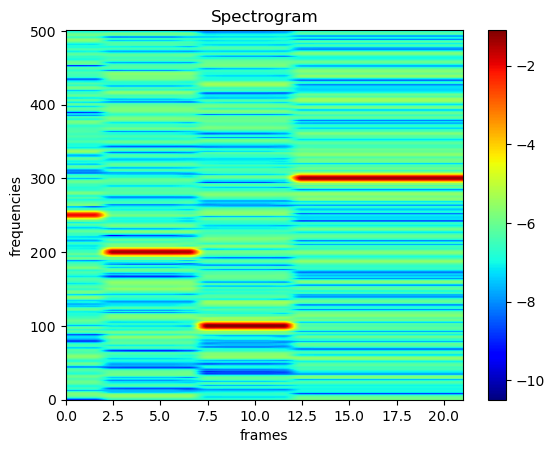

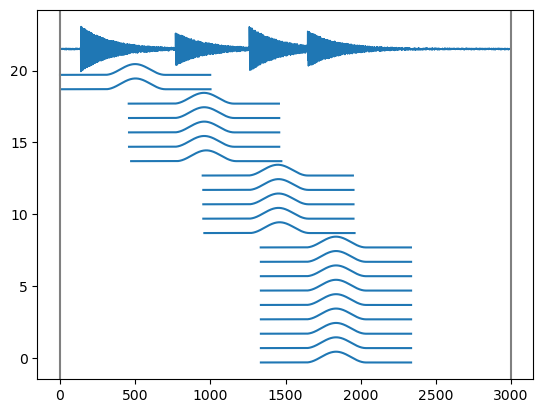

In [60]:
dstft = DSTFT(
    x,
    win_length=400,
    support=1_000,
    stride=100,
    win_requires_grad=False,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
    win_min=100,
)
params = [{"params": dstft.parameters(), "lr": 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=99,
)

for epoch in range(10_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < 0.1:
        break

print(epoch)
dstft.print(spec, x, bar=True, weights=False)

Time-varying window and hop length

1673


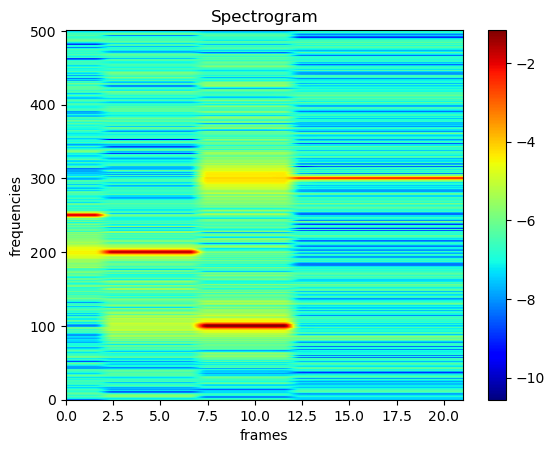

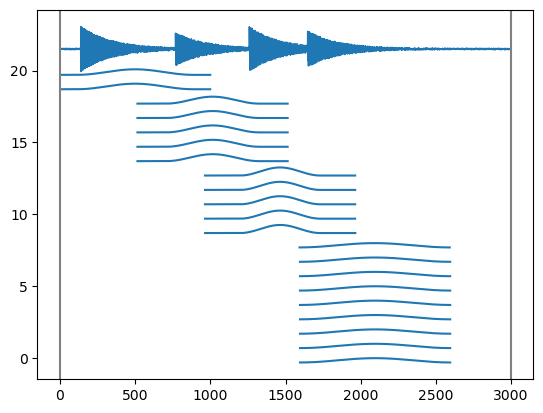

In [61]:
dstft = DSTFT(
    x,
    win_length=400,
    support=1_000,
    stride=100,
    win_requires_grad=True,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
    win_min=100,
)
params = [{"params": dstft.parameters(), "lr": 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=99,
)

for epoch in range(10_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < .1:
        break

print(epoch)
dstft.print(spec, x, bar=True, weights=False)